In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE


from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
data_folder = Path("/home/aniket/Music/notebooks/data/titanic")

In [3]:
train_data = pd.read_csv(data_folder/"train.csv")
test_data = pd.read_csv(data_folder/"test.csv")

#test_label = pd.read_csv(data_folder/"gender_submission.csv")

In [4]:
#test_data = test_data.set_index('PassengerId').join(test_label.set_index('PassengerId'))
#test_data.reset_index(inplace=True)

test_data.head()

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
pat_title = '\s([A-Za-z]+)\.'
train_data['title'] = train_data['Name'].str.extract(pat = pat_title)
test_data['title'] = test_data['Name'].str.extract(pat = pat_title)

In [7]:
pat_ticket = '(\s|^)([0-9]+)$'
t1 = train_data['Ticket'].str.extractall(pat = pat_ticket).reset_index()
t2 = test_data['Ticket'].str.extractall(pat = pat_ticket).reset_index()

train_data['ticket_number'] = t1.iloc[:,3].astype(str).astype(int)
test_data['ticket_number'] = t2.iloc[:,3].astype(str).astype(int)

In [8]:
train_data['title'] = train_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')
test_data['title'] = test_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')

In [9]:
train_data['EmbarkedGroup'] = train_data.Embarked.map(defaultdict(lambda: 1,S= 0, C= 1, Q= 1),na_action='ignore')
test_data['EmbarkedGroup'] = test_data.Embarked.map(defaultdict(lambda: 1,S= 0, C= 1, Q= 1),na_action='ignore')

In [10]:
train_data[['Pclass','Fare']].groupby(['Pclass'],as_index=False).mean()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [11]:
train_data['FamilyMembers'] = train_data['SibSp'] + train_data['Parch'] 
test_data['FamilyMembers'] = test_data['SibSp'] + test_data['Parch'] 


In [12]:
train_data.loc[train_data['FamilyMembers'] == 0, 'solo'] = 1
train_data.loc[train_data['FamilyMembers'] > 0, 'solo'] = 0

test_data.loc[train_data['FamilyMembers'] == 0, 'solo'] = 1
test_data.loc[train_data['FamilyMembers'] > 0, 'solo'] = 0

In [13]:
train_data.groupby('SibSp').size()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

In [14]:
age_labels=['A1','A2','A3','A4','A5']
age_bins=[0,15,30,45,65,99]
category = pd.cut(train_data.Age,bins=age_bins,labels=age_labels)
category = category.cat.add_categories('UNKNOWN').fillna('UNKNOWN')
train_data.insert(5,'AgeGroup',category)


fare_bins=[0,25,50,1000]
fare_labels=['Low','Mid','High']
category = pd.cut(train_data.Fare,bins=fare_bins,labels=fare_labels)
train_data.insert(6,'FareGroup',category)

familyMembers_bins=[-1,0,1,2,100]
familyMembers_labels=['F1','F2','F3','F4']
category = pd.cut(train_data.FamilyMembers,bins=familyMembers_bins,labels=familyMembers_labels)
train_data.insert(6,'FamilyMembersGroup',category)

parch_bins=[-1,0,100]
parch_labels=['0','1']
category = pd.cut(train_data.Parch,bins=parch_bins,labels=parch_labels)
train_data.insert(6,'ParchGroup',category)

sibSp_bins=[-1,0,100]
sibSp_labels=['0','1']
category = pd.cut(train_data.SibSp,bins=sibSp_bins,labels=sibSp_labels)
train_data.insert(6,'SibSpGroup',category)


In [15]:
category = pd.cut(test_data.Age,bins=age_bins,labels=age_labels)
category = category.cat.add_categories('UNKNOWN').fillna('UNKNOWN')
test_data.insert(5,'AgeGroup',category)

category = pd.cut(test_data.Fare,bins=fare_bins,labels=fare_labels)
test_data.insert(6,'FareGroup',category)

category = pd.cut(test_data.FamilyMembers,bins=familyMembers_bins,labels=familyMembers_labels)
test_data.insert(7,'FamilyMembersGroup',category)

category = pd.cut(test_data.Parch,bins=parch_bins,labels=parch_labels)
test_data.insert(6,'ParchGroup',category)

category = pd.cut(test_data.SibSp,bins=sibSp_bins,labels=sibSp_labels)
test_data.insert(6,'SibSpGroup',category)

In [16]:
train_data.isna().any()

PassengerId           False
Survived              False
Pclass                False
Name                  False
Sex                   False
AgeGroup              False
SibSpGroup            False
ParchGroup            False
FamilyMembersGroup    False
FareGroup              True
Age                    True
SibSp                 False
Parch                 False
Ticket                False
Fare                  False
Cabin                  True
Embarked               True
title                 False
ticket_number          True
EmbarkedGroup          True
FamilyMembers         False
solo                  False
dtype: bool

In [17]:
train_data[['Fare','Pclass']].groupby('Pclass').std()

,Fare
Pclass,
1,78.380373
2,13.417399
3,11.778142


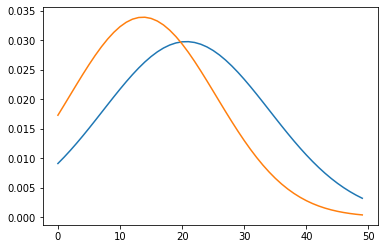

In [18]:
x_axis = np.arange(0, 50, 1)
plt.plot(norm.pdf(x_axis,20.662183,13.417399),label = 'Pclass2')
plt.plot(norm.pdf(x_axis,13.675550,11.778142),label = 'Pclass3')

(array([  4.,  10., 311.,  14.,  52.,  23.,  21.,   4.,  18.,   8.,   0.,
          6.,   0.,   6.,   0.,   0.,   7.,   0.,   0.,   7.]),
 array([ 0.    ,  3.4775,  6.955 , 10.4325, 13.91  , 17.3875, 20.865 ,
        24.3425, 27.82  , 31.2975, 34.775 , 38.2525, 41.73  , 45.2075,
        48.685 , 52.1625, 55.64  , 59.1175, 62.595 , 66.0725, 69.55  ]),
 <a list of 20 Patch objects>)

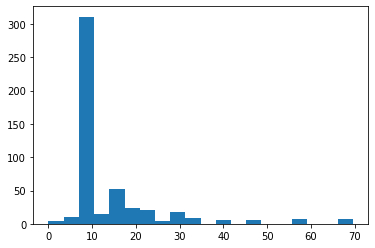

In [19]:
p1 = train_data['Fare'].loc[train_data['Pclass']==1] 
p2 = train_data['Fare'].loc[train_data['Pclass']==2] 
p3 = train_data['Fare'].loc[train_data['Pclass']==3] 
#plt.hist(p1,bins=20)
#plt.hist(p2,bins=20)
plt.hist(p3,bins=20)

In [20]:
train_data['Pclass'].loc[train_data['Pclass']==2]

9      2
15     2
17     2
20     2
21     2
      ..
866    2
874    2
880    2
883    2
886    2
Name: Pclass, Length: 184, dtype: int64

In [21]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'AgeGroup',
       'SibSpGroup', 'ParchGroup', 'FamilyMembersGroup', 'FareGroup', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title',
       'ticket_number', 'EmbarkedGroup', 'FamilyMembers', 'solo'],
      dtype='object')

In [22]:
train_data.replace([np.inf, -np.inf], np.nan,inplace=True)
test_data.replace([np.inf, -np.inf], np.nan,inplace=True)

In [23]:
numeric_features = [
    'Age',
    'Fare',
    'ticket_number',
    'Parch',
    'SibSp'
]

categorical_features = [
    "Pclass",
    "Sex",
    'Embarked',
    'solo',
    'title'

]

In [24]:
features_used_to_train = numeric_features + categorical_features

In [25]:
X = train_data[features_used_to_train]
X_pred = test_data[features_used_to_train]

In [26]:
y = train_data['Survived']
#Y_test = test_data['Survived']

In [27]:
X.head()

,Age,Fare,ticket_number,Parch,SibSp,Pclass,Sex,Embarked,solo,title
0,22.0,7.2500,21171.0,0,1,3,male,S,0.0,0
1,38.0,71.2833,17599.0,0,1,1,female,C,0.0,1
2,26.0,7.9250,3101282.0,0,0,3,female,S,1.0,2
3,35.0,53.1000,113803.0,0,1,1,female,S,0.0,1
4,35.0,8.0500,373450.0,0,0,3,male,S,1.0,0


#imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
#imp_most_frequent = SimpleImputer(missing_values=np.nan, ,strategy='most_frequent')
ctImputer = ColumnTransformer([
                        ("Imputer1", SimpleImputer(missing_values=np.nan, strategy='most_frequent'),categoricalColumns )
                        ,("Imputer2", SimpleImputer(missing_values=np.nan, strategy='median'), numericalColumns)
                        ,("Normalization", MinMaxScaler(),numericalColumns)
                    ],
                       remainder="passthrough")


ctNormalization = ColumnTransformer([
                        ("Normalization", MinMaxScaler(),[3,4])
                        ],
                       remainder="passthrough")

ctEncoder = ColumnTransformer([
                        ("Encoding", OneHotEncoder(),[2,3,4])
                        ],
                       remainder="passthrough")





In [28]:
numeric_transformer = Pipeline(steps=[
                ("Imputer2", SimpleImputer(missing_values=np.nan, strategy='constant'))
                        ,("Normalization", MinMaxScaler())
            ])


categorical_transformer = Pipeline(steps=[
                        ("Imputer1", SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
                        ,("Encoding", OneHotEncoder())
                        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

In [29]:
X = preprocessor.fit_transform(train_data)

In [30]:
X[0]

array([0.275     , 0.01415106, 0.00682645, 0.        , 0.125     ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 0.        ])

X= ctImputer.fit_transform(X)
X= ctNormalization.fit_transform(X)
X = ctEncoder.fit_transform(X)

In [31]:
pca = PCA(n_components=10)
#pca = TruncatedSVD(10)
#pca = FactorAnalysis(10)

In [32]:
X = pca.fit_transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X
y_train = y

X_pred = ctImputer.transform(X_pred)
X_pred = ctNormalization.transform(X_pred)
X_pred = ctEncoder.transform(X_pred)

In [34]:
X_pred = preprocessor.fit_transform(X_pred)
X_pred  = pca.transform(X_pred)

In [35]:
#np.where(pd.isnull(X_pred))

In [36]:
clf = RandomForestClassifier(max_depth=20, random_state=0)
#clf = svm.SVC(C=10000,kernel='rbf',gamma=0.001,probability=True)
#clf3 = AdaBoostClassifier(n_estimators=10, random_state=0)
#clf = KNeighborsClassifier(n_neighbors=3)

clf = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2)],voting='soft', weights=[1, 1])

In [37]:
#clf.fit(X_train,y_train)
clf.fit(X_train,y_train)

/home/aniket/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [38]:
y_test_pred= clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.7877094972067039

In [39]:
scores = cross_val_score(clf,X,y,cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.05)


In [40]:
confusion_matrix(y_test, y_test_pred)

array([[86, 19],
       [19, 55]])


y_pred= clf.predict(X_pred)

res = pd.DataFrame({'PassengerId' : test_data['PassengerId'].values,'Survived' : y_pred}
                   ,columns=['PassengerId','Survived'])

res.to_csv(data_folder/"output.csv" , index=False)

In [41]:
mask = ((y_test != y_test_pred) & (y_test == 0))
falsePositive = y_test[mask].index

In [42]:
mask = ((y_test != y_test_pred) & (y_test == 1))
falseNegative = y_test[mask].index

In [43]:
mask = ((y_test == y_test_pred) & (y_test == 1))
true_positive = y_test[mask].index

In [44]:
mask = ((y_test == y_test_pred) & (y_test == 0))
true_negative = y_test[mask].index

In [45]:
fn_df = train_data.iloc[falseNegative]

In [46]:
fn_df.sort_values('Pclass')

,PassengerId,Survived,Pclass,Name,Sex,AgeGroup,SibSpGroup,ParchGroup,FamilyMembersGroup,FareGroup,...,Parch,Ticket,Fare,Cabin,Embarked,title,ticket_number,EmbarkedGroup,FamilyMembers,solo
712,713,1,1,"Taylor, Mr. Elmer Zebley",male,A4,1,0,F2,High,...,0,19996,52.0000,C126,S,0,17757.0,0.0,1,0.0
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,A3,1,0,F2,High,...,0,11753,52.5542,D19,S,0,36963.0,0.0,1,0.0
447,448,1,1,"Seward, Mr. Frederic Kimber",male,A3,0,0,F1,Mid,...,0,113794,26.5500,NaN,S,0,34651.0,0.0,0,1.0
23,24,1,1,"Sloper, Mr. William Thompson",male,A2,0,0,F1,Mid,...,0,113788,35.5000,A6,S,0,113788.0,0.0,0,1.0
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,A3,0,0,F1,Mid,...,0,111426,26.5500,NaN,C,0,2123.0,1.0,0,1.0
889,890,1,1,"Behr, Mr. Karl Howell",male,A2,0,0,F1,Mid,...,0,111369,30.0000,C148,C,0,NaN,1.0,0,1.0
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,UNKNOWN,0,0,F1,Mid,...,0,111427,26.5500,NaN,S,0,382651.0,0.0,0,1.0
512,513,1,1,"McGough, Mr. James Robert",male,A3,0,0,F1,Mid,...,0,PC 17473,26.2875,E25,S,0,36967.0,0.0,0,1.0
209,210,1,1,"Blank, Mr. Henry",male,A3,0,0,F1,Mid,...,0,112277,31.0000,A31,C,0,3101311.0,1.0,0,1.0
673,674,1,2,"Wilhelms, Mr. Charles",male,A3,0,0,F1,Low,...,0,244270,13.0000,NaN,S,0,4138.0,0.0,0,1.0


In [47]:
fn_df.groupby(['Pclass','Sex']).size()

Pclass  Sex   
1       male      9
2       male      1
3       female    5
        male      4
dtype: int64

In [48]:
columns_to_be_displayed = ['Pclass','Sex','Age','solo','title','EmbarkedGroup']
fn_df[columns_to_be_displayed].sort_values(columns_to_be_displayed)

,Pclass,Sex,Age,solo,title,EmbarkedGroup
889,1,male,26.0,1.0,0,1.0
23,1,male,28.0,1.0,0,0.0
447,1,male,34.0,1.0,0,0.0
604,1,male,35.0,1.0,0,1.0
512,1,male,36.0,1.0,0,0.0
209,1,male,40.0,1.0,0,1.0
621,1,male,42.0,0.0,0,0.0
712,1,male,48.0,0.0,0,0.0
507,1,male,NaN,1.0,0,0.0
673,2,male,31.0,1.0,0,0.0


In [49]:
var = 'EmbarkedGroup'
train_data[[var,'Survived']].groupby(var).mean()

,Survived
EmbarkedGroup,
0.0,0.336957
1.0,0.502041


In [50]:
train_data[['Survived']].mean()

Survived    0.383838
dtype: float64

In [51]:
mask = ((fn_df['Pclass']==1) & (train_data['Age'] <= 45))
train_data['Survived'].loc[ mask ].mean()

1.0

In [52]:
bins = np.arange(0,80,2)
labels = np.arange(1,79,2)
category=pd.cut(train_data.Age,bins=bins,labels=labels)
train_data.insert(8,'age_bins',category)

In [53]:
mask = ((train_data['Pclass']==1) & (train_data['Sex'] == 'male'))
train_subset = train_data[mask]

ValueError: x and y must be the same size

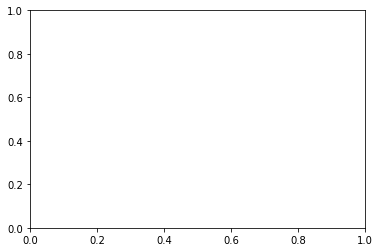

In [54]:
plt.scatter(labels,train_subset[['Survived','FareGroup']].groupby('FareGroup').mean())

In [ ]:
train_data.groupby('EmbarkedGroup').mean()

## PCA Analysis

pca = PCA().fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Model based on Class

filter = (train_data['Pclass']==1 & (train_data['Sex']=='female'))
train_subset = train_data.loc[filter]
train_subset = train_subset[features_used_to_train]

y1 = y[train_subset.index]

train_subset

X1 = preprocessor.fit_transform(train_subset)
#X1  = pca.transform(X1)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

clf =  RandomForestClassifier(max_depth=20, random_state=0)

clf.fit(X_train,y_train)

scores = cross_val_score(clf,X,y,cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

train_data[31]

In [ ]:
plt.scatter(train_data['ticket_number'],train_data['Survived'])